# Описание хода работы

Импортим нужные библиотеки

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

Загружаем данные и делаем предобработку и избавляем отсутствующие значения. Также разбивая датасет на 2 части.

In [20]:
train_data = pd.read_csv("../processed_train.csv")
valid_data = pd.read_csv("../valid/processed_valid.csv")

# Предобработка данных
def preprocess_data(df):
    # Удаляем столбец 'report_date', если он существует
    if 'report_date' in df.columns:
        df = df.drop(columns='report_date')
    
    # Удаляем столбцы с большим количеством пропусков
    df = df.loc[:, df.isnull().mean() < 0.8]
    
    # Разделяем данные на классы
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]
    return df_target_0, df_target_1


Убираем все нечисловые столбцы. Заполняем пропуски нулями. Объединяем две части датасета в один

In [21]:
train_data = train_data.select_dtypes(exclude=["object"])
train_data = train_data.fillna(0)
df_target_0, df_target_1 = preprocess_data(train_data)

valid_data = valid_data.select_dtypes(exclude=["object"])
valid_data = valid_data.fillna(0)
df_target_2, df_target_3 = preprocess_data(valid_data)

Заполнение пропусков с использованием KNN

In [22]:
from sklearn.impute import KNNImputer
df_filled_0 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_0), columns=df_target_0.columns)
df_filled_1 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_1), columns=df_target_1.columns)
combined_train = pd.concat([df_filled_0, df_filled_1])

df_filled_2 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_2), columns=df_target_2.columns)
df_filled_3 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_3), columns=df_target_3.columns)
combined_valid = pd.concat([df_filled_2, df_filled_3])

Нормализация данных. Разделение данных на обучающую и тестовую выборки

In [23]:
X_train = combined_train.drop(columns='target')
y_train = combined_train['target']

X_valid = combined_valid.drop(columns='target')
y_valid = combined_valid['target']

# Убедитесь, что признаки в X_valid совпадают с X_train
train_features = X_train.columns
extra_features = set(X_valid.columns) - set(train_features)
if extra_features:
    print(f"Лишние признаки в valid_data: {extra_features}")
    # Удаляем лишние признаки из X_valid
    X_valid = X_valid.drop(columns=extra_features)

missing_features = set(train_features) - set(X_valid.columns)
if missing_features:
    print(f"Отсутствующие признаки в valid_data: {missing_features}")
    # Добавляем отсутствующие признаки в X_valid с нулевыми значениями
    for feature in missing_features:
        X_valid[feature] = 0

# Упорядочиваем признаки в X_valid, чтобы они совпадали с X_train
X_valid = X_valid[train_features]

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)  # Масштабируем валидационные данные с помощью обученного scaler

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42, n_jobs=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

Лишние признаки в valid_data: {'col1385', 'col505', 'col1257', 'col46', 'col1266', 'col1329', 'col1278', 'col1775', 'col1005', 'col1704', 'col481', 'col509', 'col7', 'col1150', 'col1658', 'col1321', 'col1425', 'col1365', 'col15', 'col1679', 'col1301', 'col1526', 'col235', 'col2549', 'col1401', 'col989', 'col1799', 'col1703', 'col1345', 'col2561', 'col2584', 'col110', 'col1697', 'col501', 'col489', 'col36', 'col2297', 'col2439', 'col1751', 'col2367', 'col1269', 'col1265', 'col31', 'col35', 'col27', 'col39', 'col1274', 'col8', 'col1014', 'col230', 'col1262', 'col1277', 'col1684', 'col1317', 'col1516', 'col1727', 'col485'}
Отсутствующие признаки в valid_data: {'col1', 'col29', 'col1193', 'col1682', 'col109', 'col1807', 'col25', 'col47', 'col1189', 'col3', 'col1661', 'col261', 'col2575', 'col1778', 'col33', 'col1013', 'col965', 'col5', 'col1708', 'col229', 'col1330', 'col1706'}


Обучение модели Градиентный бустинг (Gradient Boosting)

In [24]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Количество деревьев
    max_depth=10,       # Максимальная глубина дерева
    learning_rate=0.1, # Скорость обучения
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_valid_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
fpr_valid, tpr_valid, _ = metrics.roc_curve(y_valid, y_valid_pred_proba)
auc_valid = metrics.roc_auc_score(y_valid, y_valid_pred_proba)
print(f"AUC на валидационных данных (XGBoost): {auc_valid:.3f}")

AUC на валидационных данных (XGBoost): 0.741


Построение ROC-кривой с использованием matplotlib

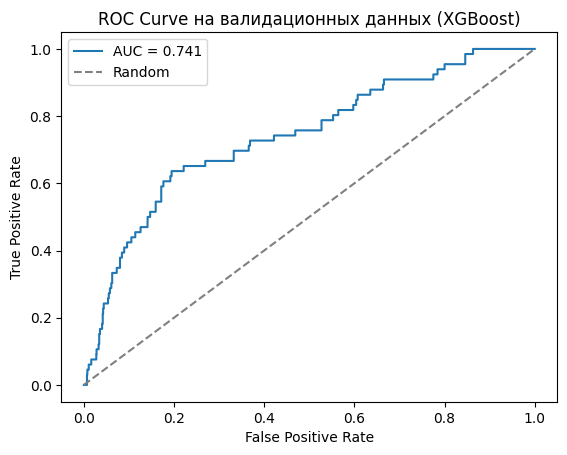

In [25]:
plt.plot(fpr_valid, tpr_valid, label=f'AUC = {auc_valid:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на валидационных данных (XGBoost)')
plt.legend()
plt.show()